In [127]:
import pandas as pd
import matplotlib.pyplot as plt #Scatterplot
import seaborn as sb
import numpy as np

In [128]:
from sklearn.preprocessing import MinMaxScaler
# Scatter matrix
from pandas.plotting import scatter_matrix

# MP2

## Ingesting the data

In [129]:
#The data is placed in an folder so we load the data through the folder with \
data1 = pd.read_excel("wine-data\winequality-red.xlsx", header=1)
data2 = pd.read_excel("wine-data\winequality-white.xlsx", header=1)

### Aggregating the data together into one data file - but first we add a column named type

In [130]:
#Adding the type
data1["type"] = "red"
data2["type"] = "white"

# Merge/concatenate - the ignore_index resets the index numbers
wine = pd.concat([data1, data2], ignore_index=True)

In [131]:
#Shows a random sample, to show that the data is mixed
wine.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
3686,8.3,0.17,0.31,1.5,0.049,48.0,153.0,0.99420,3.12,0.58,9.4,6,white
3908,8.1,0.28,0.34,1.3,0.035,11.0,126.0,0.99232,3.14,0.50,9.8,6,white
1588,7.2,0.66,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6,red
5995,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,5,white
5818,7.0,0.44,0.24,12.1,0.056,68.0,210.0,0.99718,3.05,0.50,9.5,5,white
616,9.6,0.60,0.50,2.3,0.079,28.0,71.0,0.99970,3.50,0.57,9.7,5,red
4346,7.3,0.26,0.33,11.8,0.057,48.0,127.0,0.99693,3.10,0.55,10.0,6,white
2993,5.6,0.49,0.13,4.5,0.039,17.0,116.0,0.99070,3.42,0.90,13.7,7,white
1522,6.1,0.32,0.25,2.3,0.071,23.0,58.0,0.99633,3.42,0.97,10.6,5,red
1994,6.8,0.27,0.12,1.3,0.040,87.0,168.0,0.99200,3.18,0.41,10.0,5,white


## Cleaning the data

In [132]:
#We use shape to show the size of the dataset, through the number of observations and how many variables there are
wine.shape

(6497, 13)

In [133]:
#Finding missing values (null) - It shows how many of the different variables has null values
print(wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


### Since there are no null values, we do not need to drop them

In [134]:
#Shows how many duplicated values there are. It compares all of the columns.
wine.duplicated().sum()

np.int64(1177)

### We therefore have 1177 duplicates

In [135]:
#This shows the first five duplicates.
duplicates = wine[wine.duplicated()]
print(duplicates.head())

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            6.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.90      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

    alcohol  quality type  
4       9.4        5  red  
11     10.5       

In [136]:
#Dropping the 1177 duplicates and resetting the index
wine.drop_duplicates(inplace=True, ignore_index=True)

### Checking for damaged values

In [137]:
#Negative values - 
(wine.drop(columns="type") < 0).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [138]:
#pH value 7 or bigger for wine, as wine is acid and 7 is neutral - 
wine[(wine['pH']>7)].sum()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                   0
type                      0
dtype: object

## The outliers for the "accepted" wine values

In [139]:
def check_min_max(list, expected_range):
    report = []
    for col, (min_val, max_val) in expected_range.items():
        count = ((list[col] < min_val) | (list[col] > max_val)).sum()
        report.append({"column": col, "outliers": count})

    report_df = pd.DataFrame(report)
    print(report_df)

In [140]:
#Our expected ranges for red wine
expected_ranges_red = {
    "fixed acidity": (4.6, 15.9),
    "volatile acidity": (0.12, 1.58),
    "citric acid": (0.0, 1.0),
    "residual sugar": (0.9, 15.5),
    "chlorides": (0.012, 0.611),
    "free sulfur dioxide": (1, 72),
    "total sulfur dioxide": (6, 289),
    "density": (0.99007, 1.00369),
    "pH": (2.74, 4.01),
    "sulphates": (0.33, 2.0),
    "alcohol": (8.4, 14.9),
    "quality": (3, 8)
}
red_wine = wine[wine["type"] == "red"]

check_min_max(red_wine, expected_ranges_red)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [141]:
#Our expected ranges for white wine
expected_ranges_white = {
    "fixed acidity": (3.8, 14.2),
    "volatile acidity": (0.08, 1.10),
    "citric acid": (0.0, 1.66),
    "residual sugar": (0.6, 65.8),
    "chlorides": (0.009, 0.346),
    "free sulfur dioxide": (2, 289),
    "total sulfur dioxide": (9, 440),
    "density": (0.98711, 1.03898),
    "pH": (2.72, 3.82),
    "sulphates": (0.22, 1.08),
    "alcohol": (8.0, 14.2),
    "quality": (3, 9)
}

#Right now we are only checking for the values of white wine, so we need to filter on the type of wine
white_wine = wine[wine["type"] == "white"]

check_min_max(white_wine, expected_ranges_white)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [142]:
#Shows the count, mean std fopr the collective winelist
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [143]:
#Description of red wine - the list is made previously: red_wine = wine[wine["type"] == "red"]
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [144]:
#Description of white wine - the list is made previously: white_wine = wine[wine["type"] == "white"]
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [145]:
#The shape of red wine after cleaning
red_wine.shape

(1359, 13)

In [146]:
#The shape of white wine after cleaning
white_wine.shape

(3961, 13)

## Endcoding

In [147]:
#Pre Label encoding - Categorical Encoding
wine.dtypes

wine["type"] = wine["type"].astype("category")

wine.dtypes

cat_data = wine.select_dtypes('category').columns

# print these columns only
wine[cat_data].sample(10)

categorical_data = wine[cat_data]

In [148]:
# Label Endcoding which is converting the text values into numerical values

cats = categorical_data["type"].unique()

categorical_data = wine[["type"]].copy()
categorical_data["type_encoded"] = categorical_data["type"].cat.codes

In [149]:
# adding the encoded column to the original dataframe and dropping the text column
# White wine = 1 and red wine = 0
wine["type_encoded"] = wine["type"].cat.codes

wine_transformed = wine.drop(["type"], axis=1)

### Normalization

In [150]:
# Sørg for, at kolonnen "type_encoded" er til stede i red_wine og white_wine
red_wine["type_encoded"] = wine[wine["type"] == "red"]["type_encoded"]
white_wine["type_encoded"] = wine[wine["type"] == "white"]["type_encoded"]

# Fjern kolonnen "type" fra red_wine og white_wine
red_wine_transformed = red_wine.drop(columns=["type"]).copy()
white_wine_transformed = white_wine.drop(columns=["type"]).copy()

# normalization - Scaling the data to a range of 0 to 1
scaler = MinMaxScaler()

# Fit og transformér hele datasættet
all_wine_norm = scaler.fit_transform(wine_transformed)

# Brug transform() for at genbruge skalaen på red_wine og white_wine
red_wine_norm = scaler.transform(red_wine_transformed)
white_wine_norm = scaler.transform(white_wine_transformed)

# Konverter tilbage til DataFrame for at bevare kolonnenavne
all_wine_norm = pd.DataFrame(all_wine_norm, columns=wine_transformed.columns)
red_wine_norm = pd.DataFrame(red_wine_norm, columns=red_wine_transformed.columns)
white_wine_norm = pd.DataFrame(white_wine_norm, columns=white_wine_transformed.columns)

# Udskriv resultater
print(all_wine_norm.head())
print(red_wine_norm.head())
print(white_wine_norm.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.297521          0.413333     0.000000        0.019939   0.111296   
1       0.330579          0.533333     0.000000        0.030675   0.147841   
2       0.330579          0.453333     0.024096        0.026074   0.137874   
3       0.611570          0.133333     0.337349        0.019939   0.109635   
4       0.297521          0.386667     0.000000        0.018405   0.109635   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034722              0.064516  0.206092  0.612403   0.191011   
1             0.083333              0.140553  0.186813  0.372093   0.258427   
2             0.048611              0.110599  0.190669  0.418605   0.241573   
3             0.055556              0.124424  0.209948  0.341085   0.202247   
4             0.041667              0.078341  0.206092  0.612403   0.191011   

    alcohol   quality  type_encoded  
0  0.202899  0.333

C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\3023249505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_wine["type_encoded"] = wine[wine["type"] == "red"]["type_encoded"]
C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\3023249505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_wine["type_encoded"] = wine[wine["type"] == "white"]["type_encoded"]


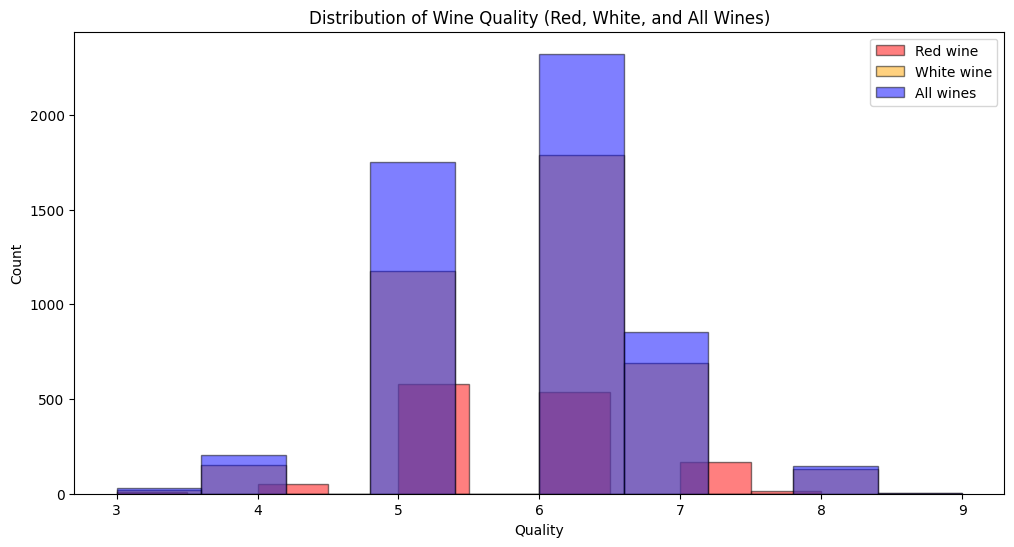

In [151]:
# normal distrubted histogram -> bellcurve

# Histogram af kvalitet for rød, hvid og alle vine
plt.figure(figsize=(12, 6))

# Histogram for rødvin
plt.hist(wine[wine["type"] == "red"]["quality"], bins=10, alpha=0.5, label="Red wine", color="red", edgecolor="black")

# Histogram for hvidvin
plt.hist(wine[wine["type"] == "white"]["quality"], bins=10, alpha=0.5, label="White wine", color="orange", edgecolor="black")

# Histogram for alle vine
plt.hist(wine["quality"], bins=10, alpha=0.5, label="All wines", color="blue", edgecolor="black")

# Tilføj labels og titel
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality (Red, White, and All Wines)")
plt.legend()
plt.show()

## Exploration

### Correlation

In [152]:
# Calculates the correlation values
pre_norm_corr_all = wine.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
pre_norm_corr_all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,0.214752,0.330328,-0.104439,0.288918,-0.281590,-0.327471,0.478180,-0.271182,0.304844,-0.102573,-0.080092,-0.486253
volatile acidity,0.214752,1.000000,-0.384192,-0.163696,0.367626,-0.349039,-0.400716,0.308452,0.246687,0.227772,-0.065411,-0.265205,-0.645335
citric acid,0.330328,-0.384192,1.000000,0.146189,0.055199,0.130849,0.194835,0.094758,-0.344735,0.059183,-0.005496,0.097954,0.183759
residual sugar,-0.104439,-0.163696,0.146189,1.000000,-0.123094,0.398717,0.487519,0.520930,-0.234522,-0.174717,-0.305242,-0.056830,0.328695
chlorides,0.288918,0.367626,0.055199,-0.123094,1.000000,-0.186615,-0.269817,0.371867,0.025823,0.405051,-0.269601,-0.202137,-0.499517
free sulfur dioxide,-0.281590,-0.349039,0.130849,0.398717,-0.186615,1.000000,0.720488,0.006166,-0.141747,-0.198244,-0.170012,0.054002,0.465326
total sulfur dioxide,-0.327471,-0.400716,0.194835,0.487519,-0.269817,0.720488,1.000000,0.006711,-0.222956,-0.275836,-0.249004,-0.050296,0.694229
density,0.478180,0.308452,0.094758,0.520930,0.371867,0.006166,0.006711,1.000000,0.034273,0.282690,-0.667811,-0.326434,-0.429377
pH,-0.271182,0.246687,-0.344735,-0.234522,0.025823,-0.141747,-0.222956,0.034273,1.000000,0.168150,0.097314,0.039733,-0.310919
sulphates,0.304844,0.227772,0.059183,-0.174717,0.405051,-0.198244,-0.275836,0.282690,0.168150,1.000000,-0.017232,0.041884,-0.490364


In [153]:
# Calculates the correlation values
post_norm_corr_red = red_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,-0.255124,0.667437,0.111025,0.085886,-0.140580,-0.103777,0.670195,-0.686685,0.190269,-0.061596,0.119024,NaN
volatile acidity,-0.255124,1.000000,-0.551248,-0.002449,0.055154,-0.020945,0.071701,0.023943,0.247111,-0.256948,-0.197812,-0.395214,NaN
citric acid,0.667437,-0.551248,1.000000,0.143892,0.210195,-0.048004,0.047358,0.357962,-0.550310,0.326062,0.105108,0.228057,NaN
residual sugar,0.111025,-0.002449,0.143892,1.000000,0.026656,0.160527,0.201038,0.324522,-0.083143,-0.011837,0.063281,0.013640,NaN
chlorides,0.085886,0.055154,0.210195,0.026656,1.000000,0.000749,0.045773,0.193592,-0.270893,0.394557,-0.223824,-0.130988,NaN
free sulfur dioxide,-0.140580,-0.020945,-0.048004,0.160527,0.000749,1.000000,0.667246,-0.018071,0.056631,0.054126,-0.080125,-0.050463,NaN
total sulfur dioxide,-0.103777,0.071701,0.047358,0.201038,0.045773,0.667246,1.000000,0.078141,-0.079257,0.035291,-0.217829,-0.177855,NaN
density,0.670195,0.023943,0.357962,0.324522,0.193592,-0.018071,0.078141,1.000000,-0.355617,0.146036,-0.504995,-0.184252,NaN
pH,-0.686685,0.247111,-0.550310,-0.083143,-0.270893,0.056631,-0.079257,-0.355617,1.000000,-0.214134,0.213418,-0.055245,NaN
sulphates,0.190269,-0.256948,0.326062,-0.011837,0.394557,0.054126,0.035291,0.146036,-0.214134,1.000000,0.091621,0.248835,NaN


In [154]:
# Calculates the correlation values
post_norm_corr_white = white_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,-0.019214,0.298959,0.083620,0.024036,-0.058396,0.082425,0.266091,-0.431274,-0.017453,-0.110788,-0.124636,NaN
volatile acidity,-0.019214,1.000000,-0.163228,0.098340,0.086287,-0.102471,0.102315,0.060603,-0.046954,-0.021150,0.046815,-0.190678,NaN
citric acid,0.298959,-0.163228,1.000000,0.106269,0.132590,0.091681,0.122845,0.160076,-0.183015,0.049442,-0.076514,0.007065,NaN
residual sugar,0.083620,0.098340,0.106269,1.000000,0.076091,0.306835,0.409583,0.820498,-0.165997,-0.020503,-0.398167,-0.117339,NaN
chlorides,0.024036,0.086287,0.132590,0.076091,1.000000,0.101272,0.191145,0.253088,-0.090573,0.017871,-0.356928,-0.217739,NaN
free sulfur dioxide,-0.058396,-0.102471,0.091681,0.306835,0.101272,1.000000,0.619437,0.294638,-0.007750,0.037932,-0.251768,0.010507,NaN
total sulfur dioxide,0.082425,0.102315,0.122845,0.409583,0.191145,0.619437,1.000000,0.536868,0.008239,0.136544,-0.446643,-0.183356,NaN
density,0.266091,0.060603,0.160076,0.820498,0.253088,0.294638,0.536868,1.000000,-0.063734,0.082048,-0.760162,-0.337805,NaN
pH,-0.431274,-0.046954,-0.183015,-0.165997,-0.090573,-0.007750,0.008239,-0.063734,1.000000,0.142353,0.093095,0.123829,NaN
sulphates,-0.017453,-0.021150,0.049442,-0.020503,0.017871,0.037932,0.136544,0.082048,0.142353,1.000000,-0.022850,0.053200,NaN


In [155]:
# Calculates the correlation values
post_norm_corr_all = all_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,0.214752,0.330328,-0.104439,0.288918,-0.281590,-0.327471,0.478180,-0.271182,0.304844,-0.102573,-0.080092,-0.486253
volatile acidity,0.214752,1.000000,-0.384192,-0.163696,0.367626,-0.349039,-0.400716,0.308452,0.246687,0.227772,-0.065411,-0.265205,-0.645335
citric acid,0.330328,-0.384192,1.000000,0.146189,0.055199,0.130849,0.194835,0.094758,-0.344735,0.059183,-0.005496,0.097954,0.183759
residual sugar,-0.104439,-0.163696,0.146189,1.000000,-0.123094,0.398717,0.487519,0.520930,-0.234522,-0.174717,-0.305242,-0.056830,0.328695
chlorides,0.288918,0.367626,0.055199,-0.123094,1.000000,-0.186615,-0.269817,0.371867,0.025823,0.405051,-0.269601,-0.202137,-0.499517
free sulfur dioxide,-0.281590,-0.349039,0.130849,0.398717,-0.186615,1.000000,0.720488,0.006166,-0.141747,-0.198244,-0.170012,0.054002,0.465326
total sulfur dioxide,-0.327471,-0.400716,0.194835,0.487519,-0.269817,0.720488,1.000000,0.006711,-0.222956,-0.275836,-0.249004,-0.050296,0.694229
density,0.478180,0.308452,0.094758,0.520930,0.371867,0.006166,0.006711,1.000000,0.034273,0.282690,-0.667811,-0.326434,-0.429377
pH,-0.271182,0.246687,-0.344735,-0.234522,0.025823,-0.141747,-0.222956,0.034273,1.000000,0.168150,0.097314,0.039733,-0.310919
sulphates,0.304844,0.227772,0.059183,-0.174717,0.405051,-0.198244,-0.275836,0.282690,0.168150,1.000000,-0.017232,0.041884,-0.490364


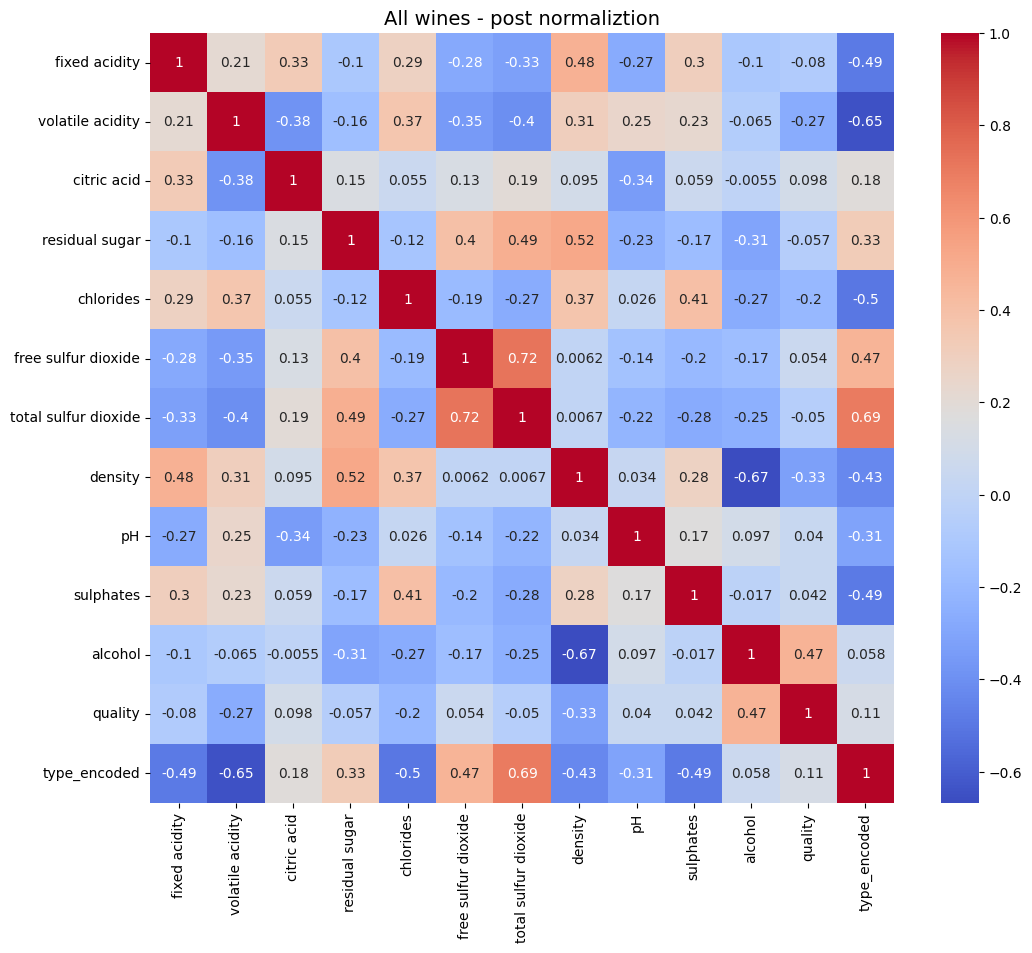

In [157]:
#heatmap with normalized data
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_all, annot=True, cmap='coolwarm')
plt.title("All wines - post normaliztion", fontsize=14)
plt.show()

## Correlations for all wines seems to low everywhere,so it warrents that we check red and white for them selves

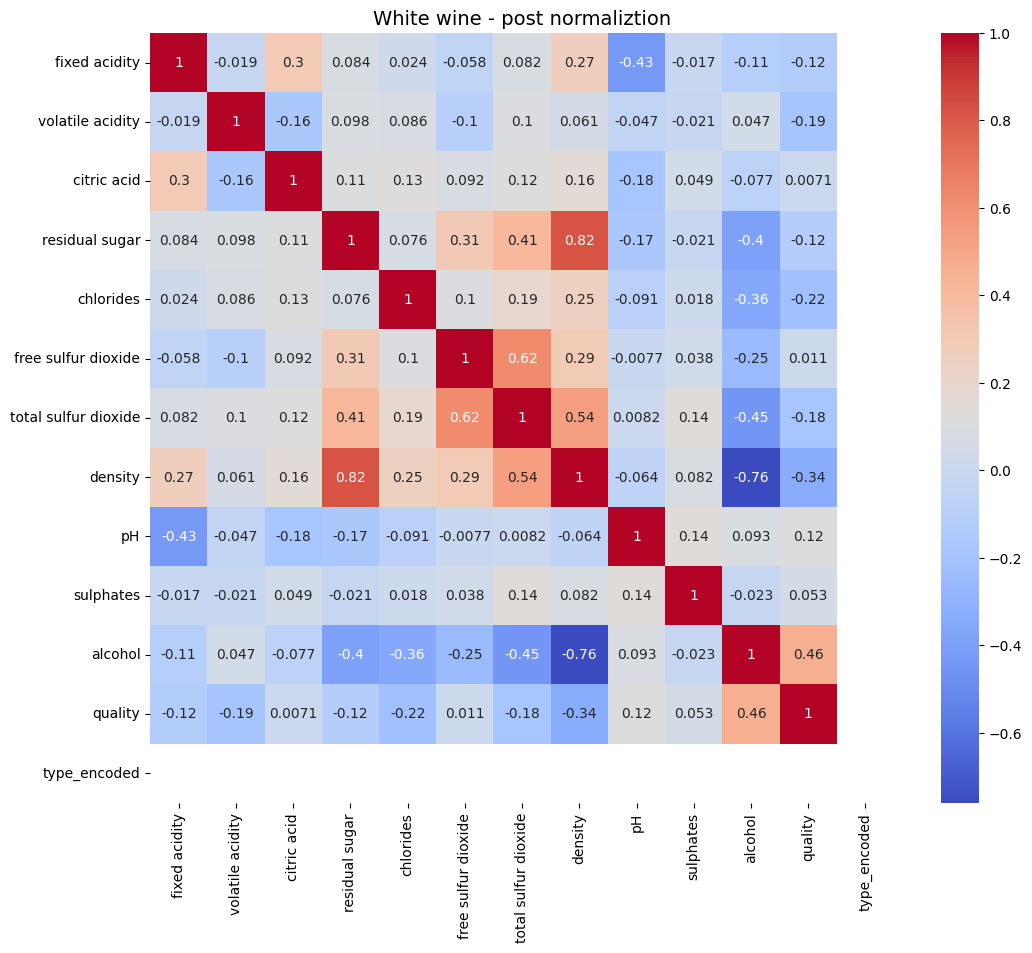

In [158]:
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_white, annot=True, cmap='coolwarm')
plt.title("White wine - post normaliztion", fontsize=14)

plt.show()

## The correlations for white wine:
it is high for:  
    1: density and residual sugar 
    2: density and alcohol

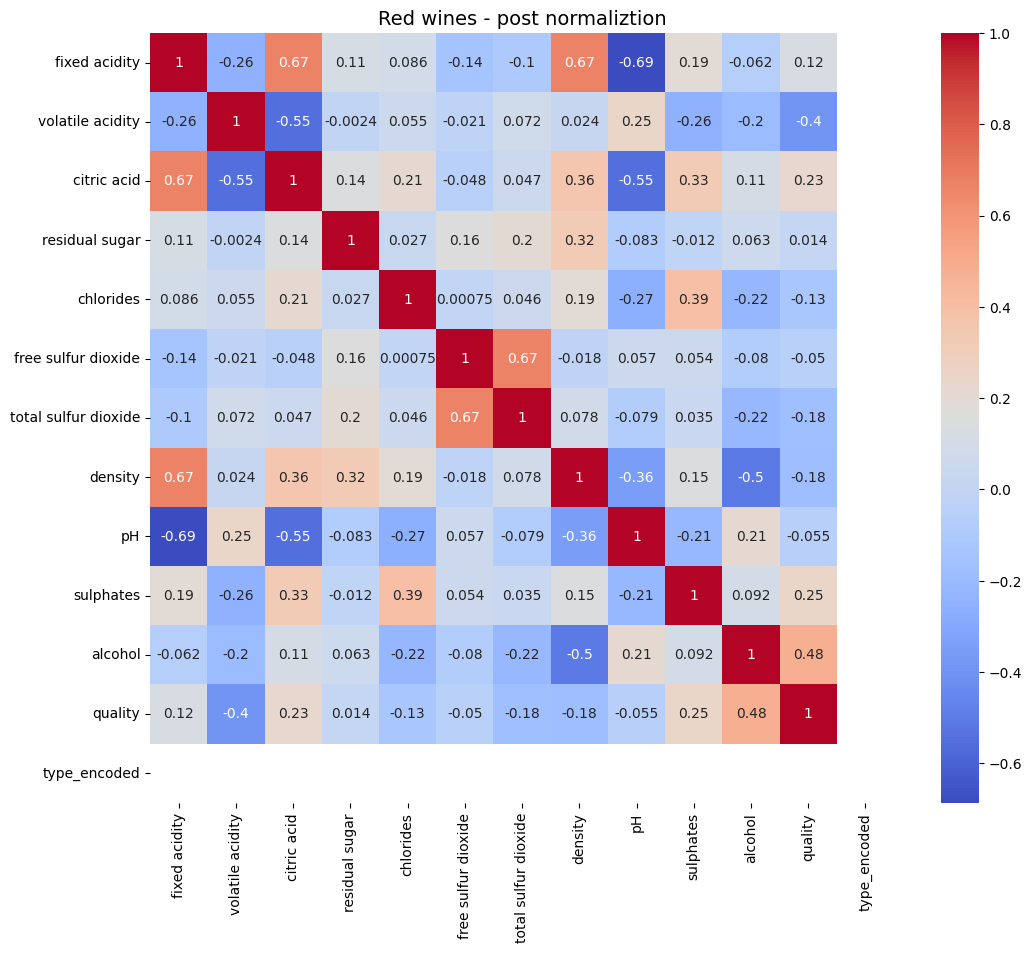

In [159]:
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_red, annot=True, cmap='coolwarm')
plt.title("Red wines - post normaliztion", fontsize=14)

plt.show()

## The correlations for red wine:
it is high for:
    1. fixed acidity and Ph
    2. fixed acidity and density
low for:
    1. pH and citric acid
    2.alcohol and density


## conclusion for correlations

1. we want to see why residual sugar and alcohol doesn't correlate the same for red and white wine
2. we want to see why acids doesn't have a high correlations with pH

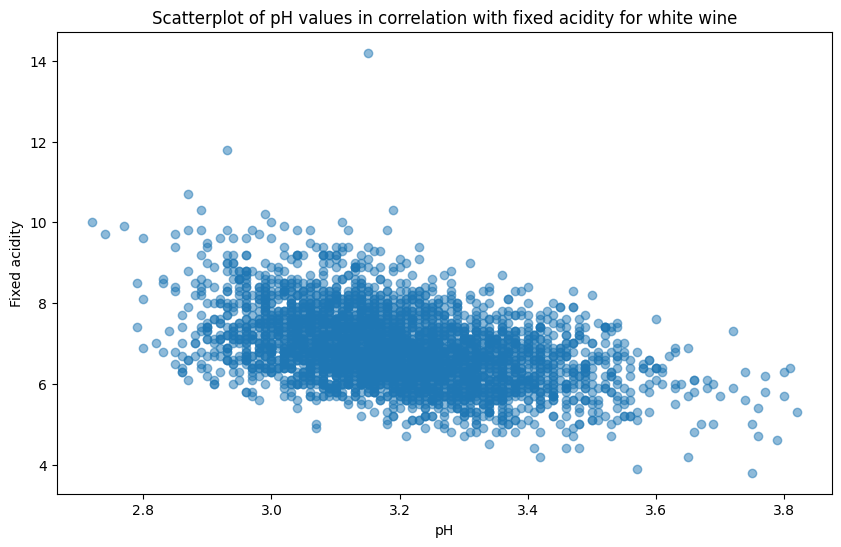

In [182]:
#Scatterplot: x = pH, y = fixed acidity
plt.figure(figsize=(10,6))
plt.scatter(white_wine["pH"], white_wine["fixed acidity"], alpha=0.5)
plt.xlabel("pH")
plt.ylabel("Fixed acidity")
plt.title("Scatterplot of pH values in correlation with fixed acidity for white wine")
plt.show()

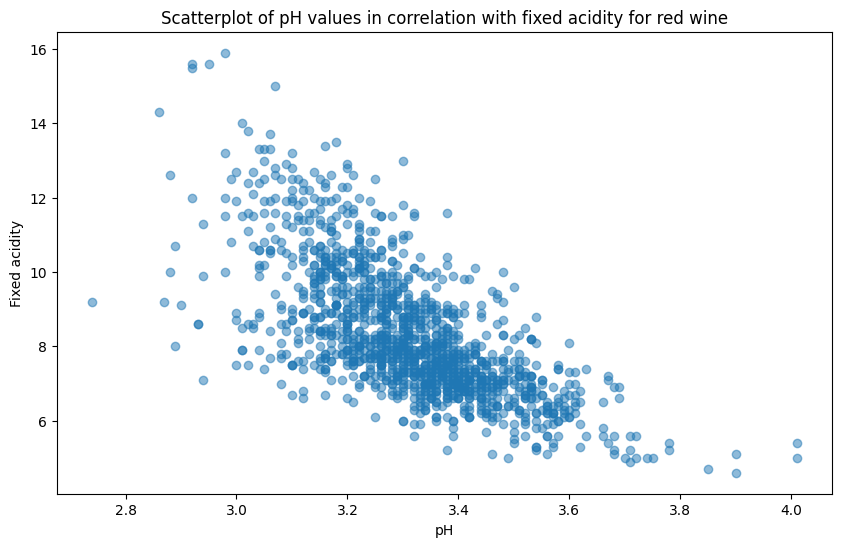

In [183]:
#Scatterplot: x = pH, y = fixed acidity
plt.figure(figsize=(10,6))
plt.scatter(red_wine["pH"], red_wine["fixed acidity"], alpha=0.5)
plt.xlabel("pH")
plt.ylabel("Fixed acidity")
plt.title("Scatterplot of pH values in correlation with fixed acidity for red wine")
plt.show()

## Findings? explore more before conclusion
/ the correlation between fixed acidity and pH seems to be different between red and white could partly due we have 3 times the amount of data points for white wine /

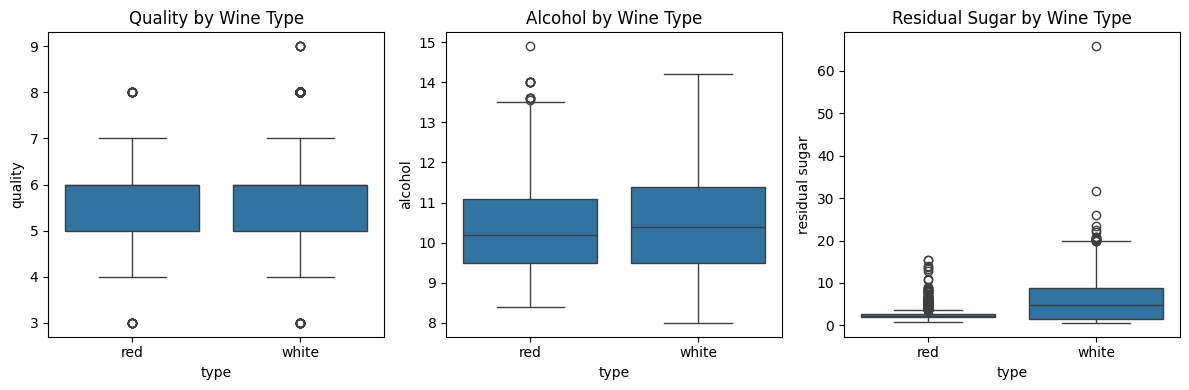

In [160]:
# a. Boxplots for at sammenligne fordelingen af quality, alcohol og residual sugar
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sb.boxplot(x="type", y="quality", data=wine)
plt.title("Quality by Wine Type")
plt.subplot(1,3,2)
sb.boxplot(x="type", y="alcohol", data=wine)
plt.title("Alcohol by Wine Type")
plt.subplot(1,3,3)
sb.boxplot(x="type", y="residual sugar", data=wine)
plt.title("Residual Sugar by Wine Type")
plt.tight_layout()
plt.show()

In [161]:
# which type of wine has higher average quality, how big is the difference?
mean_quality = wine.groupby("type")["quality"].mean()
print("average quality:\n", mean_quality)
print("difference:", abs(mean_quality["white"] - mean_quality["red"]))

# white has on average higher quality

average quality:
 type
red      5.623252
white    5.854835
Name: quality, dtype: float64
difference: 0.2315822462534367


C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\2172461371.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_quality = wine.groupby("type")["quality"].mean()


In [162]:
# which type of wine has higher average level of alcohol?
mean_alcohol = wine.groupby("type")["alcohol"].mean()
print("Average alcohol:\n", mean_alcohol)
print("difference:", abs(mean_alcohol["white"] - mean_alcohol["red"]))

# white has on average higher level of alcohol

Average alcohol:
 type
red      10.432315
white    10.589358
Name: alcohol, dtype: float64
difference: 0.15704247824183604


C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\1182970469.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_alcohol = wine.groupby("type")["alcohol"].mean()


In [163]:
# which one has higher average quantity of residual sugar?

mean_sugar = wine.groupby("type")["residual sugar"].mean()
print("Average residual sugar:\n", mean_sugar)
print("difference:", abs(mean_sugar["white"] - mean_sugar["red"]))

# white has on average higher quantity of residual sugar

Average residual sugar:
 type
red      2.523400
white    5.914819
Name: residual sugar, dtype: float64
difference: 3.3914199315288736


C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\3742301362.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_sugar = wine.groupby("type")["residual sugar"].mean()


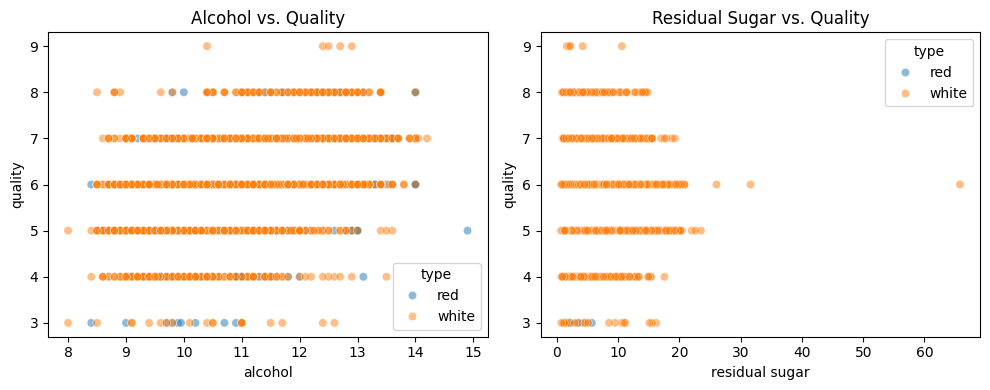

In [164]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.scatterplot(x="alcohol", y="quality", hue="type", data=wine, alpha=0.5)
plt.title("Alcohol vs. Quality")
plt.subplot(1,2,2)
sb.scatterplot(x="residual sugar", y="quality", hue="type", data=wine, alpha=0.5)
plt.title("Residual Sugar vs. Quality")
plt.tight_layout()
plt.show()

In [165]:
print("Korrelationskoefficient (alcohol vs. quality):")
print(wine[["alcohol", "quality"]].corr())
print("Korrelationskoefficient (residual sugar vs. quality):")
print(wine[["residual sugar", "quality"]].corr())

Korrelationskoefficient (alcohol vs. quality):
          alcohol   quality
alcohol  1.000000  0.469422
quality  0.469422  1.000000
Korrelationskoefficient (residual sugar vs. quality):
                residual sugar  quality
residual sugar         1.00000 -0.05683
quality               -0.05683  1.00000


In [166]:
#Binning wines in groups of 5 and 10 bins.

def find_highest_density(df, bins, label):
    #Bin the pH column
    binned = pd.cut(df["pH"], bins=bins)
    
    counts = binned.value_counts().sort_index()
    
    #Print the densest bin.
    max_bin = counts.idxmax()
    print(f"{label}: Number of bins = {bins} Highest density in pH range of {max_bin} with {counts.max()} samples")
    return counts

print("5 bins")
find_highest_density(wine, bins=5, label="All wines")
find_highest_density(wine[wine["type_encoded"]==0], bins=5, label="Red wines")
find_highest_density(wine[wine["type_encoded"]==1], bins=5, label="White wines")

print("\n10 bins")
find_highest_density(wine, bins=10, label="All wines")
find_highest_density(wine[wine["type_encoded"]==0], bins=10, label="Red wines")
find_highest_density(wine[wine["type_encoded"]==1], bins=10, label="White wines")

5 bins
All wines: Number of bins = 5 Highest density in pH range of (2.978, 3.236] with 2687 samples
Red wines: Number of bins = 5 Highest density in pH range of (3.248, 3.502] with 764 samples
White wines: Number of bins = 5 Highest density in pH range of (3.16, 3.38] with 1765 samples

10 bins
All wines: Number of bins = 10 Highest density in pH range of (3.107, 3.236] with 1718 samples
Red wines: Number of bins = 10 Highest density in pH range of (3.248, 3.375] with 470 samples
White wines: Number of bins = 10 Highest density in pH range of (3.05, 3.16] with 1116 samples


pH
(2.719, 2.83]      12
(2.83, 2.94]      131
(2.94, 3.05]      521
(3.05, 3.16]     1116
(3.16, 3.27]     1095
(3.27, 3.38]      670
(3.38, 3.49]      260
(3.49, 3.6]       113
(3.6, 3.71]        28
(3.71, 3.82]       15
Name: count, dtype: int64

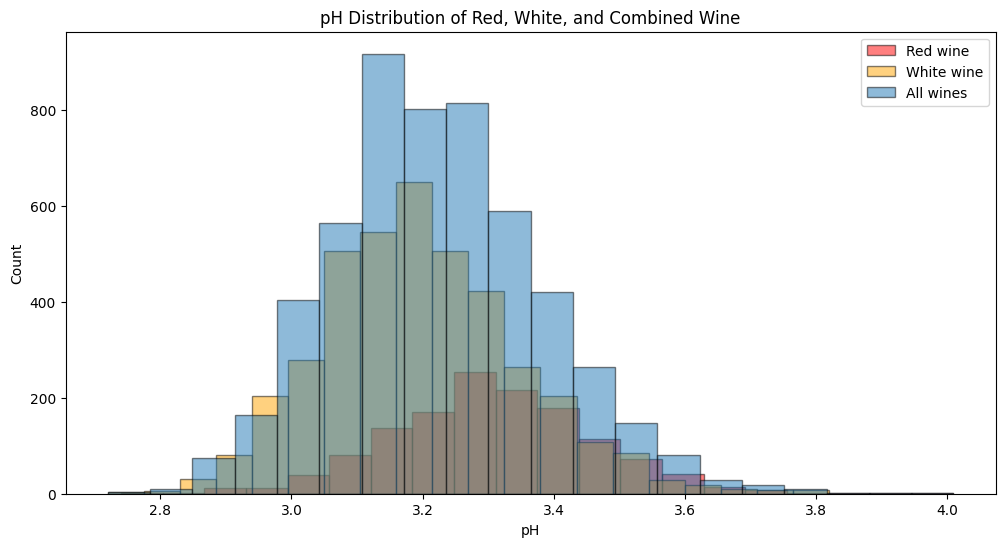

In [167]:
#Visual graph for pH density on red, white and all wines combined.
plt.figure(figsize=(12,6))

#Change bins=x the higer x is the more detailed the graph gets.
plt.hist(wine[wine["type_encoded"]==0]["pH"], bins=20, alpha=0.5, label="Red wine", edgecolor="black", color="red")
plt.hist(wine[wine["type_encoded"]==1]["pH"], bins=20, alpha=0.5, label="White wine", edgecolor="black", color="orange")
plt.hist(wine["pH"], bins=20, alpha=0.5, label="All wines", edgecolor="black")

plt.xlabel("pH")
plt.ylabel("Count")
plt.title("pH Distribution of Red, White, and Combined Wine")
plt.legend()
plt.show()

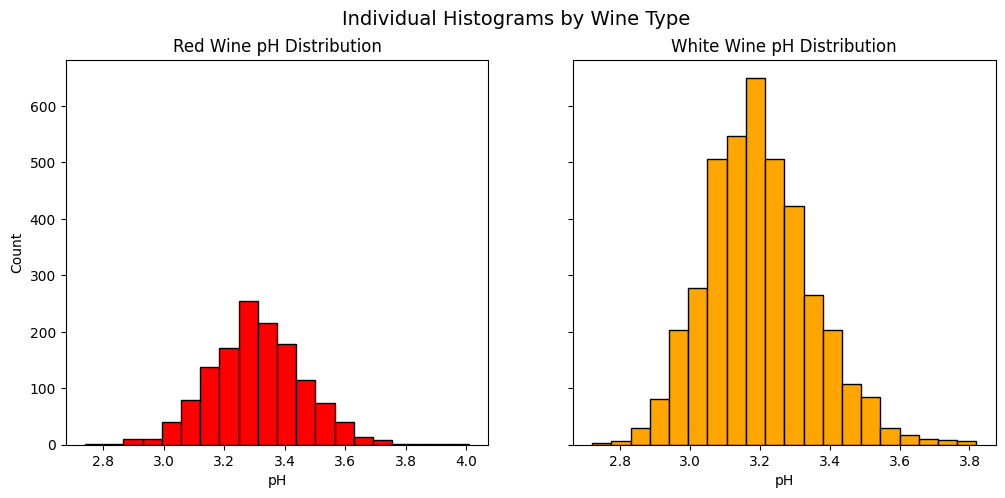

In [168]:
#Individual graphs for red and white wines.
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].hist(wine[wine["type_encoded"]==0]["pH"], bins=20, color="red", edgecolor="black")
axes[0].set_title("Red Wine pH Distribution")
axes[0].set_xlabel("pH")
axes[0].set_ylabel("Count")

axes[1].hist(wine[wine["type_encoded"]==1]["pH"], bins=20, color="orange", edgecolor="black")
axes[1].set_title("White Wine pH Distribution")
axes[1].set_xlabel("pH")

plt.suptitle("Individual Histograms by Wine Type", fontsize=14)
plt.show()

C:\Users\Rolfj\AppData\Local\Temp\ipykernel_1040\2959171248.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = wine.groupby(["pH_category", "type_encoded"]).size().unstack(fill_value=0)


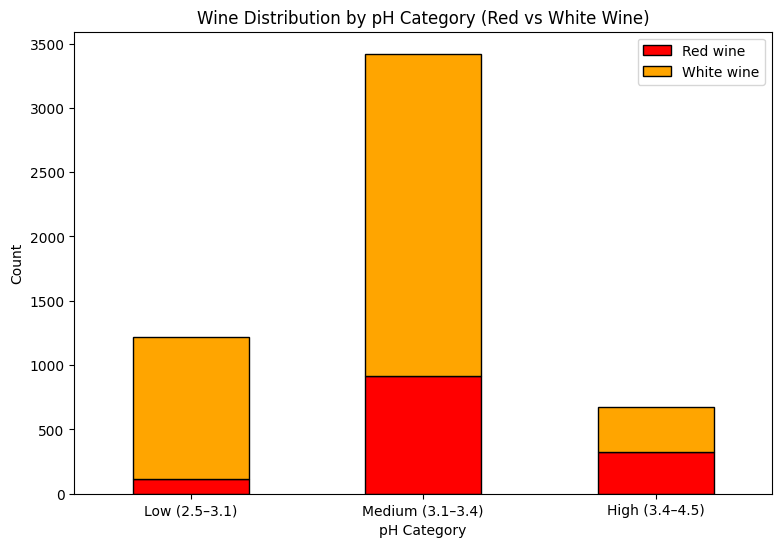

In [169]:
#Define bins and labels
bins = [2.5, 3.1, 3.4, 4.5]  
labels = ["Low", "Medium", "High"]

wine["pH_category"] = pd.cut(wine["pH"], bins=bins, labels=labels)

category_counts = wine.groupby(["pH_category", "type_encoded"]).size().unstack(fill_value=0)
category_counts.columns = ["Red wine", "White wine"]

range_labels = [
    f"Low ({bins[0]}–{bins[1]})",
    f"Medium ({bins[1]}–{bins[2]})",
    f"High ({bins[2]}–{bins[3]})"
]

ax = category_counts.plot(
    kind="bar", 
    stacked=True, 
    color=["red", "orange"], 
    edgecolor="black",
    figsize=(9,6)
)

ax.set_xlabel("pH Category")
ax.set_ylabel("Count")
ax.set_title("Wine Distribution by pH Category (Red vs White Wine)")
ax.set_xticklabels(range_labels, rotation=0)
plt.legend()
plt.show()

In [170]:
# Scatterplot: x = index (bare rækkefølgen af vin), y = pH
# plt.figure(figsize=(10,6))
# plt.scatter(wine.index, wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
# plt.xlabel("Vin index")
# plt.ylabel("pH")
# plt.title("Scatterplot af pH værdier for rød og hvid vin")
# plt.show()


In [171]:
# Scatterplot: x = x = fixed acidity, y = pH
# plt.figure(figsize=(10,6))
# plt.scatter(wine["fixed acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
# plt.xlabel("Fixed acidity")
# plt.ylabel("pH")
# plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til fixed acidity")
# plt.show()

In [172]:
# Scatterplot: x = volatile acidity, y = pH
# plt.figure(figsize=(10,6))
# plt.scatter(wine["volatile acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
# plt.xlabel("Volatile acidity")
# plt.ylabel("pH")
# plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til volatile acidity")
# plt.show()

In [173]:
# Scatterplot: x = volatile acidity, y = fixed acidity
# plt.figure(figsize=(10,6))
# plt.scatter(wine["volatile acidity"], wine["fixed acidity"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
# plt.xlabel("Volatile acidity")
# plt.ylabel("Fixed acidity")
# plt.title("Scatterplot af volatile acidity værdier for rød og hvid vin, i forhold til fixed acidity")
# plt.show()

In [174]:
# Scatterplot: x = alcohol, y = quality
# plt.figure(figsize=(10,10))
# plt.scatter(wine["alcohol"], wine["quality"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
# plt.xlabel("Alcohol")
# plt.ylabel("Quality")
# plt.title("Scatterplot af alcohol værdier for rød og hvid vin, i forhold til quality")
# plt.show()

In [175]:
#KOMMER BARE FRA CHAT
# plt.figure(figsize=(8,6))
# wine.boxplot(column="pH", by="type", grid=False, patch_artist=True,
#              boxprops=dict(facecolor="lightblue"),
#              medianprops=dict(color="red"))
# plt.title("Boxplot af pH værdier for rød vs. hvid vin")
# plt.suptitle("")  # fjerner standardtitel
# plt.xlabel("Vin type")
# plt.ylabel("pH")
# plt.show()

In [176]:
# plt.hist(wine["pH"], bins=5, edgecolor="black")
# plt.xlabel("pH")
# plt.ylabel("Frekvens")
# plt.title("Histogram af pH-værdier")
# plt.show()